# SGN-41007 Assignment Task 2 Group 37

This is group 37 report for Assignment task 2.

This assignment report is made with Jyputer notebook. 

## Importing dependecies

First part of this excercise is to import needed dependencies from Keras, Scikit-learn, Matplotlib and Numpy.
Utils is our own utility set for data loading, feature extraction and creating submission files for Kaggle competition.

In [16]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Conv2D, MaxPool2D, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from keras.regularizers import l1

import matplotlib.pyplot as plt
import utils
import numpy as np

## Using proposed crossvalidation set and extract features

Competition assignment suggested to divide dataset to predefined training and cross validation sets.

We start with loading full dataset with using our utils method `training_data`.
Utility will also encode string labels to integer values. It returns according label encoder for later inverse transform for creating submission back to label encoding.

In [17]:
X, y, X_test, y_label_encoder = utils.training_data()

Next we split dataset to given train and cross validation sets by reading `crossvalidation_train.csv` and taking indices from there and creating leave one group out split with our own implementation. During implementing this assignment, we were not familiar with already existing implementation of leave one group out in Sklearn.

In [18]:
X_train, X_cv, y_train, y_cv, cv_indices = utils.split_data(X, y)

Implementation of `split data` uses following code

In [19]:
def split_data_(X_train, y_train):
    y_cv_split = np.array(pd.read_csv("data/crossvalidation_train.csv"))
    train_indices = y_cv_split[y_cv_split[:,2] == "train"][:,0].astype(int)
    test_indices = y_cv_split[y_cv_split[:,2] == "test"][:,0].astype(int)

    X_test = X_train[train_indices, :]
    X_cv = X_train[test_indices, :]

    y_test = y_train[train_indices]
    y_cv = y_train[test_indices]

    # Array which contains "test" values marked as True and "train" as false
    mask = y_cv_split[:, 2]  == "test"
    mask = mask.astype(int)
    # "test" values marked as 0 and train values "-1" 
    mask -= 1
    cv_split_indices = PredefinedSplit(mask).split()

    return X_test, X_cv, y_test, y_cv, cv_split_indices

After this we will do label binarization for y values and also add new dimension to Training data set for 2d convolution and transpose spectrogram axes.

In [20]:
y_train = to_categorical(y_train)
y_cv = to_categorical(y_cv)

lb = LabelBinarizer()
lb.fit(y_train)
y_train = lb.transform(y_train)
y_test = lb.transform(y_cv)
num_classes = y_full.shape[1]

X_train = np.transpose(X_train, (0, 2, 1))
X_cv = np.transpose(X_cv, (0, 2, 1))
X_test = np.transpose(X_test, (0, 2, 1))

X_train = X_train[..., np.newaxis]
X_cv = X_cv[..., np.newaxis]
X_test = X_test[..., np.newaxis]

## Defining a convolutional network with Keras

Now we are ready to make Keras model with improved convolutional neural network.

This network have combined multiple convolution layers with maxpooling between them and l1 regularization for kernel. Main pattern is to have two convolution layer followed by max pooling. Finally network have Dense layers which are regularized with dropout regularization.

In [21]:
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(3, 3),
                 activation='relu',
                 padding='same',
                 kernel_regularizer=l1(0.01),
                 input_shape=(501, 40, 1))),


model.add(Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=l1(0.01),
                 activation='relu'))

model.add(MaxPool2D(2, 2))

model.add(Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=l1(0.01),
                 activation='relu'))

model.add(Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=l1(0.01),
                 activation='relu'))

model.add(MaxPool2D(2, 2))

model.add(Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=l1(0.01),
                 activation='relu'))

model.add(Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='same',
                 kernel_regularizer=l1(0.01),
                 activation='relu'))

model.add(MaxPool2D(2, 2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))

model.add(Dense(y_train.shape[1], activation='softmax'))

model.summary()

optimizer = SGD(lr=1e-3)

model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 501, 40, 32)       320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 501, 40, 32)       9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 250, 20, 32)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 250, 20, 32)       9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 250, 20, 32)       9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 125, 10, 32)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 125, 10, 32)       9248      
__________

## Training the convolutional network

Now we are ready to train the network with stochastic gradient descent optimizer and cross validate it with predefined split dataset.

For this report we only use epochs=10, because lack of proper gpu for faster calculations. 

In [24]:
optimizer = SGD(lr=1e-3)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_cv, y_cv))

Train on 3268 samples, validate on 1232 samples
Epoch 1/10
3268/3268 [==============================] - 176s 54ms/step - loss: 19.7408 - acc: 0.0805 - val_loss: 19.5343 - val_acc: 0.1023
Epoch 2/10
3268/3268 [==============================] - 174s 53ms/step - loss: 19.3392 - acc: 0.0924 - val_loss: 19.1355 - val_acc: 0.1169
Epoch 3/10
3268/3268 [==============================] - 175s 53ms/step - loss: 18.9428 - acc: 0.0799 - val_loss: 18.7415 - val_acc: 0.0771
Epoch 4/10
3268/3268 [==============================] - 174s 53ms/step - loss: 18.5509 - acc: 0.0860 - val_loss: 18.3524 - val_acc: 0.0844
Epoch 5/10
3268/3268 [==============================] - 175s 54ms/step - loss: 18.1641 - acc: 0.0921 - val_loss: 17.9680 - val_acc: 0.0844
Epoch 6/10
3268/3268 [==============================] - 176s 54ms/step - loss: 17.7821 - acc: 0.1010 - val_loss: 17.5886 - val_acc: 0.1112
Epoch 7/10
3268/3268 [==============================] - 176s 54ms/step - loss: 17.4050 - acc: 0.0900 - val_loss: 17.21

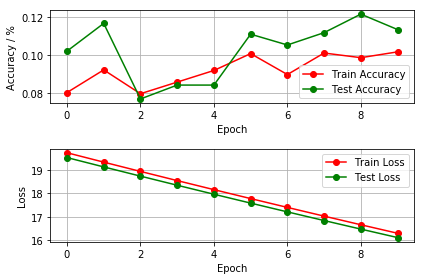

In [25]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['acc'], 'ro-', label = "Train Accuracy")
ax[0].plot(history.history['val_acc'], 'go-', label = "Test Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy / %")
ax[0].legend(loc = "best")
ax[0].grid('on')

ax[1].plot(history.history['loss'], 'ro-', label = "Train Loss")
ax[1].plot(history.history['val_loss'], 'go-', label = "Test Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc = "best")
ax[1].grid('on')

plt.tight_layout()
plt.show()

With ten epochs we are able to reach approximately 10% accuracy. Loss is decreasing constantly and we could assume that more epochs would improve accuracy.

In our local training setup, we were able to reach approximately 70% prediction accuracy against cross validation set with 80 epochs.

## Final training and submission
For final submission we trained the network with full dataset without splitting dataset to cross validation set.
We used 80 epochs to fit the network which took approximately 6h to train with Intel i7 2,5Ghz CPU on Macbook pro.

Final training gave us 83.98% accuracy and loss of 0.4393

Epoch 80/80
4500/4500 [==============================] - 199s 44ms/step - loss: 0.4393 - acc: 0.8398

Given network gave us public score of `60.933%` prediction accuracy